In [1]:
import argparse
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from datasets_prep.dataset import create_dataset
from diffusion import sample_from_model, sample_posterior, \
    q_sample_pairs, get_time_schedule, \
    Posterior_Coefficients, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf
import wandb
from copy import deepcopy
from collections import OrderedDict
import random

class ProbLoss(nn.Module):
    def __init__(self, opt):
        assert opt["loss_type"] in ["bce", "hinge"]
        super().__init__()
        self.loss_type = opt["loss_type"]
        self.device = opt["device"]
        self.ones = torch.ones(opt["batch_size"]).to(opt["device"])
        self.zeros = torch.zeros(opt["batch_size"]).to(opt["device"])
        self.bce = nn.BCEWithLogitsLoss()

    def __call__(self, logits, condition):
        assert condition in ["gen", "disc_real", "disc_fake"]
        batch_len = len(logits)

        if self.loss_type == "bce":
            if condition in ["gen", "disc_real"]:
                return self.bce(logits, self.ones[:batch_len])
            else:
                return self.bce(logits, self.zeros[:batch_len])
        
        elif self.loss_type == "hinge":
        # SPADEでのHinge lossを参考に実装
        # https://github.com/NVlabs/SPADE/blob/master/models/networks/loss.py        
            if condition == "gen":
                # Generatorでは、本物になるようにHinge lossを返す
                return -torch.mean(logits)
            elif condition == "disc_real":
                minval = torch.min(logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)
            else:
                minval = torch.min(-logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)

class RandomCutout(object):
    def __init__(self, size=8):
        self.size = size

    def __call__(self, img_batch):
        # バッチサイズと画像の高さ、幅を取得
        batch_size, channels, height, width = img_batch.size()

        for i in range(batch_size):
            # ランダムな位置を決定
            x = random.randint(0, width - self.size)
            y = random.randint(0, height - self.size)

            # カットアウトを適用
            img_batch[i, :, y:y + self.size, x:x + self.size] = 0

        return img_batch

@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        name = name.replace("module.", "")
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag

def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward()

In [2]:
from get_args import get_args
args = ["--dataset", "cifar10_no_transform", "--exp", "kl-f2-4", "--num_channels", "4", "--num_channels_dae", "128", "--num_timesteps", "4", 
			"--num_res_blocks", "2", "--batch_size", "256", "--num_epoch", "2000", "--ngf", "64", "--nz", "50", "--z_emb_dim", "256", "--n_mlp", "4", "--embedding_type", "positional", 
			"--use_ema", "--ema_decay", "0.9999", "--r1_gamma", "0.02", "--lr_d", "1.25e-4", "--lr_g", "1.6e-4", "--lazy_reg", "15", 
			"--ch_mult", "1", "2", "2", "--save_content", "--datadir", "./data/cifar-10", 
			"--master_port", "6084", "--num_process_per_node", "1", "--save_ckpt_every", "25", 
			"--current_resolution", "16", "--attn_resolutions", "32", "--num_disc_layers", "4",  "--scale_factor", "105.0", 
			"--no_lr_decay", 
            "--AutoEncoder_config", "autoencoder/config/kl-f2.yaml", 
            "--AutoEncoder_ckpt", "autoencoder/weight/kl-f2.ckpt", 
			"--rec_loss",
			"--sigmoid_learning", 
       ]

args = get_args(args)

In [23]:
from EMA import EMA
from score_sde.models.discriminator import Discriminator_large, Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp, WaveletNCSNpp

rank = 0
gpu = 0

torch.manual_seed(args.seed + rank)
torch.cuda.manual_seed(args.seed + rank)
torch.cuda.manual_seed_all(args.seed + rank)
device = torch.device('cuda:{}'.format(gpu))

batch_size = args.batch_size

nz = args.nz  # latent dimension

#latent_size = args.image_size // 8

dataset = create_dataset(args)

#features_dir = f"{args.feature_path}/{args.dataset}/{args.image_size}_features"
#labels_dir = f"{args.feature_path}/{args.dataset}/{args.image_size}_labels"
#dataset = CustomDataset(features_dir, labels_dir)

#train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
#                                                                num_replicas=args.world_size,
#                                                                rank=rank)
data_loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=args.num_workers,
                        pin_memory=True,
                        drop_last=True)
args.ori_image_size = args.image_size
args.image_size = args.current_resolution
G_NET_ZOO = {"normal": NCSNpp, "wavelet": WaveletNCSNpp}
gen_net = G_NET_ZOO[args.net_type]
disc_net = [Discriminator_small, Discriminator_large]
print("GEN: {}, DISC: {}".format(gen_net, disc_net))
netG = gen_net(args).to(device)

if args.dataset in ['cifar10', 'stl10', 'afhq_cat']:
    netD = disc_net[0](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)
else:
    netD = disc_net[1](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)

#broadcast_params(netG.parameters())
#broadcast_params(netD.parameters())

optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters(
)), lr=args.lr_d, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad, netG.parameters(
)), lr=args.lr_g, betas=(args.beta1, args.beta2))

if args.use_ema:
    optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerG, args.num_epoch, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerD, args.num_epoch, eta_min=1e-5)

# ddp
#netG = nn.parallel.DistributedDataParallel(
#    netG, device_ids=[gpu])
#netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])

"""############### DELETE TO AVOID ERROR ###############"""
# Wavelet Pooling
#if not args.use_pytorch_wavelet:
#    dwt = DWT_2D("haar")
#    iwt = IDWT_2D("haar")
#else:
#    dwt = DWTForward(J=1, mode='zero', wave='haar').cuda()
#    iwt = DWTInverse(mode='zero', wave='haar').cuda()
    

#load encoder and decoder
config_path = args.AutoEncoder_config 
ckpt_path = args.AutoEncoder_ckpt 

if args.dataset in ['cifar10', 'stl10', 'coco', 'afhq_cat']:
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    
    AutoEncoder = instantiate_from_config(config['model'])
    

    checkpoint = torch.load(ckpt_path, map_location=device)
    AutoEncoder.load_state_dict(checkpoint['state_dict'])
    AutoEncoder.eval()
    AutoEncoder.to(device)

#else:
#    AutoEncoder = load_model_from_config(config_path, ckpt_path)
"""############### END DELETING ###############"""

#AutoEncoder = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

#num_levels = int(np.log2(args.ori_image_size // args.current_resolution))

exp = args.exp
parent_dir = "./saved_info/{}".format(args.dataset)

exp_path = os.path.join(parent_dir, exp)
if rank == 0:
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        copy_source(__file__, exp_path)
        shutil.copytree('score_sde/models', os.path.join(exp_path, 'score_sde/models'))

coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

if args.resume or os.path.exists(os.path.join(exp_path, 'content.pth')):
    checkpoint_file = os.path.join(exp_path, 'content.pth')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    init_epoch = checkpoint['epoch']
    epoch = init_epoch
    # load G
    netG.load_state_dict(checkpoint['netG_dict'])
    #optimizerG.load_state_dict(checkpoint['optimizerG'])
    schedulerG.load_state_dict(checkpoint['schedulerG'])
    # load D
    netD.load_state_dict(checkpoint['netD_dict'])
    #optimizerD.load_state_dict(checkpoint['optimizerD'])
    schedulerD.load_state_dict(checkpoint['schedulerD'])

    global_step = checkpoint['global_step']
    print("=> loaded checkpoint (epoch {})"
          .format(checkpoint['epoch']))
else:
    global_step, epoch, init_epoch = 0, 0, 0

'''Sigmoid learning parameter'''
gamma = 6
beta = np.linspace(-gamma, gamma, args.num_epoch+1)
alpha = 1 - 1 / (1+np.exp(-beta))

if args.dataset in ['cifar10'] and args.class_conditional:
    class_embedding = nn.Embedding(10, nz).to(device)

nrow = 2
if args.batch_size >= 5:
    nrow = 3
if args.batch_size >= 10:
    nrow = 10

Files already downloaded and verified


NameError: name 'DataLoader' is not defined

In [3]:
device = torch.device('cuda:{}'.format(0))

batch_size = args.batch_size

nz = args.nz  # latent dimension

dataset = create_dataset(args)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=args.num_workers,
                                          pin_memory=True,
                                          
                                          drop_last=True)

Files already downloaded and verified


In [4]:
transform = transforms.RandomChoice([
    RandomCutout(size=16),
    #transforms.RandomHorizontalFlip(),
])

In [5]:
tmp = iter(data_loader)
x, y = next(tmp)

In [6]:
x.shape

torch.Size([8, 3, 32, 32])

In [7]:
x = transform(x)

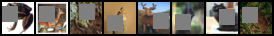

In [8]:
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display
from PIL import Image

x = (torch.clamp(x, -1, 1) + 1) / 2  # 0-1
grid_img = torchvision.utils.make_grid(x)

# TensorをPIL画像に変換して保存
ndarr = grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
im = Image.fromarray(ndarr)
display(im)

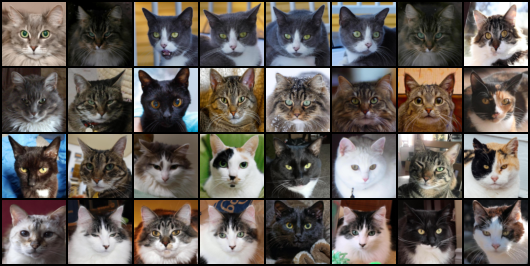

In [7]:
from PIL import Image
MEAN = [[0.5, 0.5, 0.5],[0.3053, 0.2815, 0.2438]]
STD  = [[0.5, 0.5, 0.5],[0.1789, 0.1567, 0.1587]]

def denormalize(tensor, mean, std):
    # meanとstdをtensorの形に合わせて調整
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    # データを逆正規化
    tensor = tensor * std + mean
    return tensor

# バッチを逆正規化
denorm_batch = denormalize(x, MEAN[0], STD[0])
# torchvision.utils.make_gridでバッチをグリッド画像に変換
grid_img = torchvision.utils.make_grid(denorm_batch)

# TensorをPIL画像に変換して保存
ndarr = grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
im = Image.fromarray(ndarr)
im.save('output_image.png')
display(im)

In [8]:
for epoch in range(init_epoch, args.num_epoch + 1):
    #train_sampler.set_epoch(epoch)
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    start_epoch = torch.cuda.Event(enable_timing=True)
    end_epoch = torch.cuda.Event(enable_timing=True)
    start_epoch.record()
    for iteration, (x, y) in enumerate(data_loader):
        for p in netD.parameters():
            p.requires_grad = True
        netD.zero_grad()

        for p in netG.parameters():
            p.requires_grad = False

        # sample from p(x_0)
        x0 = x.to(device, non_blocking=True)
        #x0 = x0.squeeze(dim=1)

        """################# Change here: Encoder #################"""
        with torch.no_grad():
            posterior = AutoEncoder.encode(x0)
            real_data = posterior.sample().detach()
        #print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
        #print(f'{args.scale_factor=}')
        #real_data = real_data / args.scale_factor #300.0  # [-1, 1]
        #real_data = x0
        #assert -1 <= real_data.min() < 0
        #assert 0 < real_data.max() <= 1
        """################# End change: Encoder #################"""
        # sample t
        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        
        if args.dataset in ['cifar10'] and args.class_conditional:
            y = y.to(device)
            y = y.squeeze(dim=1)
            y_emb = class_embedding(y)

        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
        x_t.requires_grad = True

        """################# Save Sample #################"""
        """
        if iteration % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {iteration}")
        if iteration % 50 == 0:
            x_t_1 = torch.randn_like(posterior.sample())
            if args.dataset in ['cifar10'] and args.class_conditional:
                y = torch.arange(0, 10).repeat(x_t_1.size(0)//10 + 1)[:x_t_1.size(0)].to(device)
                y_emb = class_embedding(y)
                fake_sample = sample_from_model(
                    pos_coeff, netG, args.num_timesteps, x_t_1, T, args, class_emb=y_emb)
            else:
                fake_sample = sample_from_model(
                    pos_coeff, netG, args.num_timesteps, x_t_1, T, args)
            fake_sample *= args.scale_factor #300
            real_sample = real_data.detach().clone()

        save_image(fake_sample, real_data, AutoEncoder, exp_path, epoch, nrow)
        """

        # train with real
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)
        errD_real = F.softplus(-D_real).mean()

        errD_real.backward(retain_graph=True)

        if args.lazy_reg is None:
            grad_penalty_call(args, D_real, x_t)
        else:
            if global_step % args.lazy_reg == 0:
                grad_penalty_call(args, D_real, x_t)

        # train with fake
        latent_z = torch.randn(batch_size, nz, device=device)
        if args.dataset in ['cifar10'] and args.class_conditional:
            x_0_predict = netG(x_tp1.detach(), t, torch.cat([latent_z, y_emb], dim=1).detach())
        else:
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errD_fake = F.softplus(output).mean()

        errD_fake.backward()

        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # update G
        for p in netD.parameters():
            p.requires_grad = False

        for p in netG.parameters():
            p.requires_grad = True
        netG.zero_grad()

        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

        latent_z = torch.randn(batch_size, nz, device=device)
        if args.dataset in ['cifar10'] and args.class_conditional:
            x_0_predict = netG(x_tp1.detach(), t, torch.cat([latent_z, y_emb], dim=1).detach())
        else:
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errG = F.softplus(-output).mean()

        # reconstructior loss
        if args.sigmoid_learning and args.rec_loss:
            ######alpha
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + alpha[epoch]*rec_loss

        elif args.rec_loss and not args.sigmoid_learning:
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + rec_loss
        

        errG.backward()
        optimizerG.step()

        global_step += 1
        if iteration % 100 == 0:
            if rank == 0:
                end.record()
                torch.cuda.synchronize()
                elapsed_time = start.elapsed_time(end)
                if args.sigmoid_learning:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, alpha: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), alpha[epoch]))
                elif args.rec_loss:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, rec_loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), rec_loss.item()))
                else:   
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item()))
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                start.record()

    if not args.no_lr_decay:

        schedulerG.step()
        schedulerD.step()

    if rank == 0:
        end_epoch.record()
        torch.cuda.synchronize()
        time_per_epoch = start_epoch.elapsed_time(end_epoch)
        #wandb.log({"G_loss": errG.item(), "D_loss": errD.item(), "alpha": alpha[epoch], "time_per_epoch": time_per_epoch / 1000})
        ########################################
        x_t_1 = torch.randn_like(posterior.sample())
        if args.dataset in ['cifar10'] and args.class_conditional:
            y = torch.arange(0, 10).repeat(x_t_1.size(0)//10 + 1)[:x_t_1.size(0)].to(device)
            y_emb = class_embedding(y)
            fake_sample = sample_from_model(
                pos_coeff, netG, args.num_timesteps, x_t_1, T, args, class_emb=y_emb)
        else:
            fake_sample = sample_from_model(
                pos_coeff, netG, args.num_timesteps, x_t_1, T, args)

        """############## CHANGE HERE: DECODER ##############"""
        #fake_sample *= args.scale_factor #300
        #real_data *= args.scale_factor #300

        """##############SAVE IMAGE##############"""
        save_image(fake_sample, real_data, AutoEncoder, exp_path, epoch, nrow)

        if args.save_content:
            if epoch % args.save_content_every == 0:
                print('Saving content.')
                content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                           'netG_dict': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                           'schedulerG': schedulerG.state_dict(), 'netD_dict': netD.state_dict(),
                           'optimizerD': optimizerD.state_dict(), 'schedulerD': schedulerD.state_dict()}
                torch.save(content, os.path.join(exp_path, 'content.pth'))

        if epoch % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(
                exp_path, 'netG_{}.pth'.format(epoch)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)


epoch 0 iteration0, G Loss: 15.543731689453125, D Loss: 1.3861949443817139, alpha: 0.9975273768433652
epoch 0 iteration100, G Loss: 25.65850830078125, D Loss: 6.20743230683729e-05, alpha: 0.9975273768433652
OUTTTT
OUTTTT
Saving content.
epoch 1 iteration0, G Loss: 30.098358154296875, D Loss: 0.00025583457318134606, alpha: 0.9973748797433398
epoch 1 iteration100, G Loss: 149.38856506347656, D Loss: 6.024087895184493e-08, alpha: 0.9973748797433398
OUTTTT
OUTTTT
Saving content.
epoch 2 iteration0, G Loss: 175.16384887695312, D Loss: 4.880401611328125, alpha: 0.9972130037809577
epoch 2 iteration100, G Loss: 226.33021545410156, D Loss: 4.410322276271472e-07, alpha: 0.9972130037809577
OUTTTT
OUTTTT
Saving content.
epoch 3 iteration0, G Loss: 324.65228271484375, D Loss: 2.2813138999208022e-42, alpha: 0.9970411754780928
epoch 3 iteration100, G Loss: 214.61581420898438, D Loss: 1.8484139218344353e-05, alpha: 0.9970411754780928
OUTTTT
OUTTTT
Saving content.
epoch 4 iteration0, G Loss: 98.9627304

In [24]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

# データ変換（リサイズとTensorに変換）
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

def load_images_from_dir(data_dir, extensions=('.png', '.jpg', '.jpeg')):
    """
    指定されたディレクトリから画像を読み込む。
    
    Args:
        data_dir (str): 画像ディレクトリのパス
        extensions (tuple): 読み込みたい画像の拡張子のタプル
        
    Returns:
        List[torch.Tensor]: 画像をTensorに変換して返すリスト
    """
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"指定されたディレクトリが存在しません: {data_dir}")
    
    all_images = []
    
    with os.scandir(data_dir) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.lower().endswith(extensions):
                img_path = entry.path
                try:
                    image = Image.open(img_path)
                    image = transform(image)
                    all_images.append(image)
                except Exception as e:
                    print(f"画像の読み込みに失敗しました: {img_path}, エラー: {e}")
    
    if len(all_images) == 0:
        raise ValueError("画像が見つかりませんでした。")

    return all_images

def calculate_mean_std(images):
    """
    画像のリストからチャンネルごとの平均と分散を計算する。
    
    Args:
        images (List[torch.Tensor]): 画像のTensorリスト
    
    Returns:
        (torch.Tensor, torch.Tensor): チャンネルごとの平均と標準偏差
    """
    all_images_tensor = torch.stack(images)
    mean = torch.mean(all_images_tensor, dim=[0, 2, 3])
    std = torch.std(all_images_tensor, dim=[0, 2, 3])
    return mean, std

# 画像ディレクトリ
data_dir = 'data/afhq/train/cat'

# 画像の読み込み
all_images = load_images_from_dir(data_dir)

# 平均と分散の計算
mean, std = calculate_mean_std(all_images)

print(f'平均: {mean}')
print(f'分散: {std ** 2}')

平均: tensor([0.4990, 0.4567, 0.4067])
分散: tensor([0.0639, 0.0611, 0.0644])


In [ ]:
afhq cat
size 512
平均: tensor([0.4985, 0.4562, 0.4062])
分散: tensor([0.0666, 0.0638, 0.0671])

size 256
平均: tensor([0.4990, 0.4567, 0.4067])
分散: tensor([0.0639, 0.0611, 0.0644])

size 128
平均: tensor([0.4986, 0.4563, 0.4064])
分散: tensor([0.0625, 0.0597, 0.0630])

平均：0.4987, 0.4564, 0.4064
分散：0.0643, 0.0615, 0.0648